<hr style="border:1px solid black"> </hr>

- **Python Libraries for Clustering**
    - pandas
    - matplotlib.pyplot
    - sklearn-metrics
    - sklearn.cluster-KMeans
    - warnings

In [198]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as gmm
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from collections import defaultdict
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn import cluster
from sklearn.metrics import silhouette_score, silhouette_samples
warnings.filterwarnings('ignore')
# Matplotlib Settings
plt.style.use(["seaborn-ticks"])
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.which"] = "both"
plt.rcParams["grid.linestyle"] = "--"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.figsize"] = (7.5, 5)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.autolayout"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.loc"] = "best"
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.titlesize"] = "x-large"
sns.set(rc=dict(plt.rcParams))


### Data understanding
<hr style="border:1px solid black"> </hr>

This collection comprises seed measurements from a variety of plant species. Each row represents the dimensions of a single seed.
The columns are as follows:

Column|Description
-|:-
area |A, the area of the seed.
perimiter |P, the length of the perimeter of the seed.
compactness| A measure of the area of the seed relative to the perimeter,(4πA/P2)
length|The length of the seed.
width|The width of the seed.
asymmetry| A measure of the asymmetry of the seed.
groove_length| The length of the groove in the seed.

-`pd.read_csv`Load Seed.csv file to read raw data and then display using `seeds.head()` for overview.
<br>**Knowledge gained:** A quick glance reveals that the dataframe has 210 rows and 7 columns, where each row represents a dimensions.

In [8]:
seeds = pd.read_csv("seeds.csv")
seeds

,area,perimeter,compactness,length,width,asymmetry,groove_length
0,15.26,14.84,0.871,5.763,3.312,2.221,5.220
1,14.88,14.57,0.881,5.554,3.333,1.018,4.956
2,14.29,14.09,0.905,5.291,3.337,2.699,4.825
3,13.84,13.94,0.895,5.324,3.379,2.259,4.805
4,16.14,14.99,0.903,5.658,3.562,1.355,5.175
...,...,...,...,...,...,...,...
205,12.19,13.20,0.878,5.137,2.981,3.631,4.870
206,11.23,12.88,0.851,5.140,2.795,4.325,5.003
207,13.20,13.66,0.888,5.236,3.232,8.315,5.056
208,11.84,13.21,0.852,5.175,2.836,3.598,5.044


-`sns.pairplot` create a scatterplot for each pair of variables in the dataframe and display them in a grid.
<br>**Knowledge gained:**
- `width` has a highly even distribution and would not assist in group differentiation.
- The subplots in the figure's bottom row illustrate distinct cluster groupings. As a result, `groove length` is a key attribute for clustering.
- The `asymmetry` trait is also useful for clustering, however not as well as the `groove length` feature.

Text(0.5, 1.03, 'Scatter Matrix')

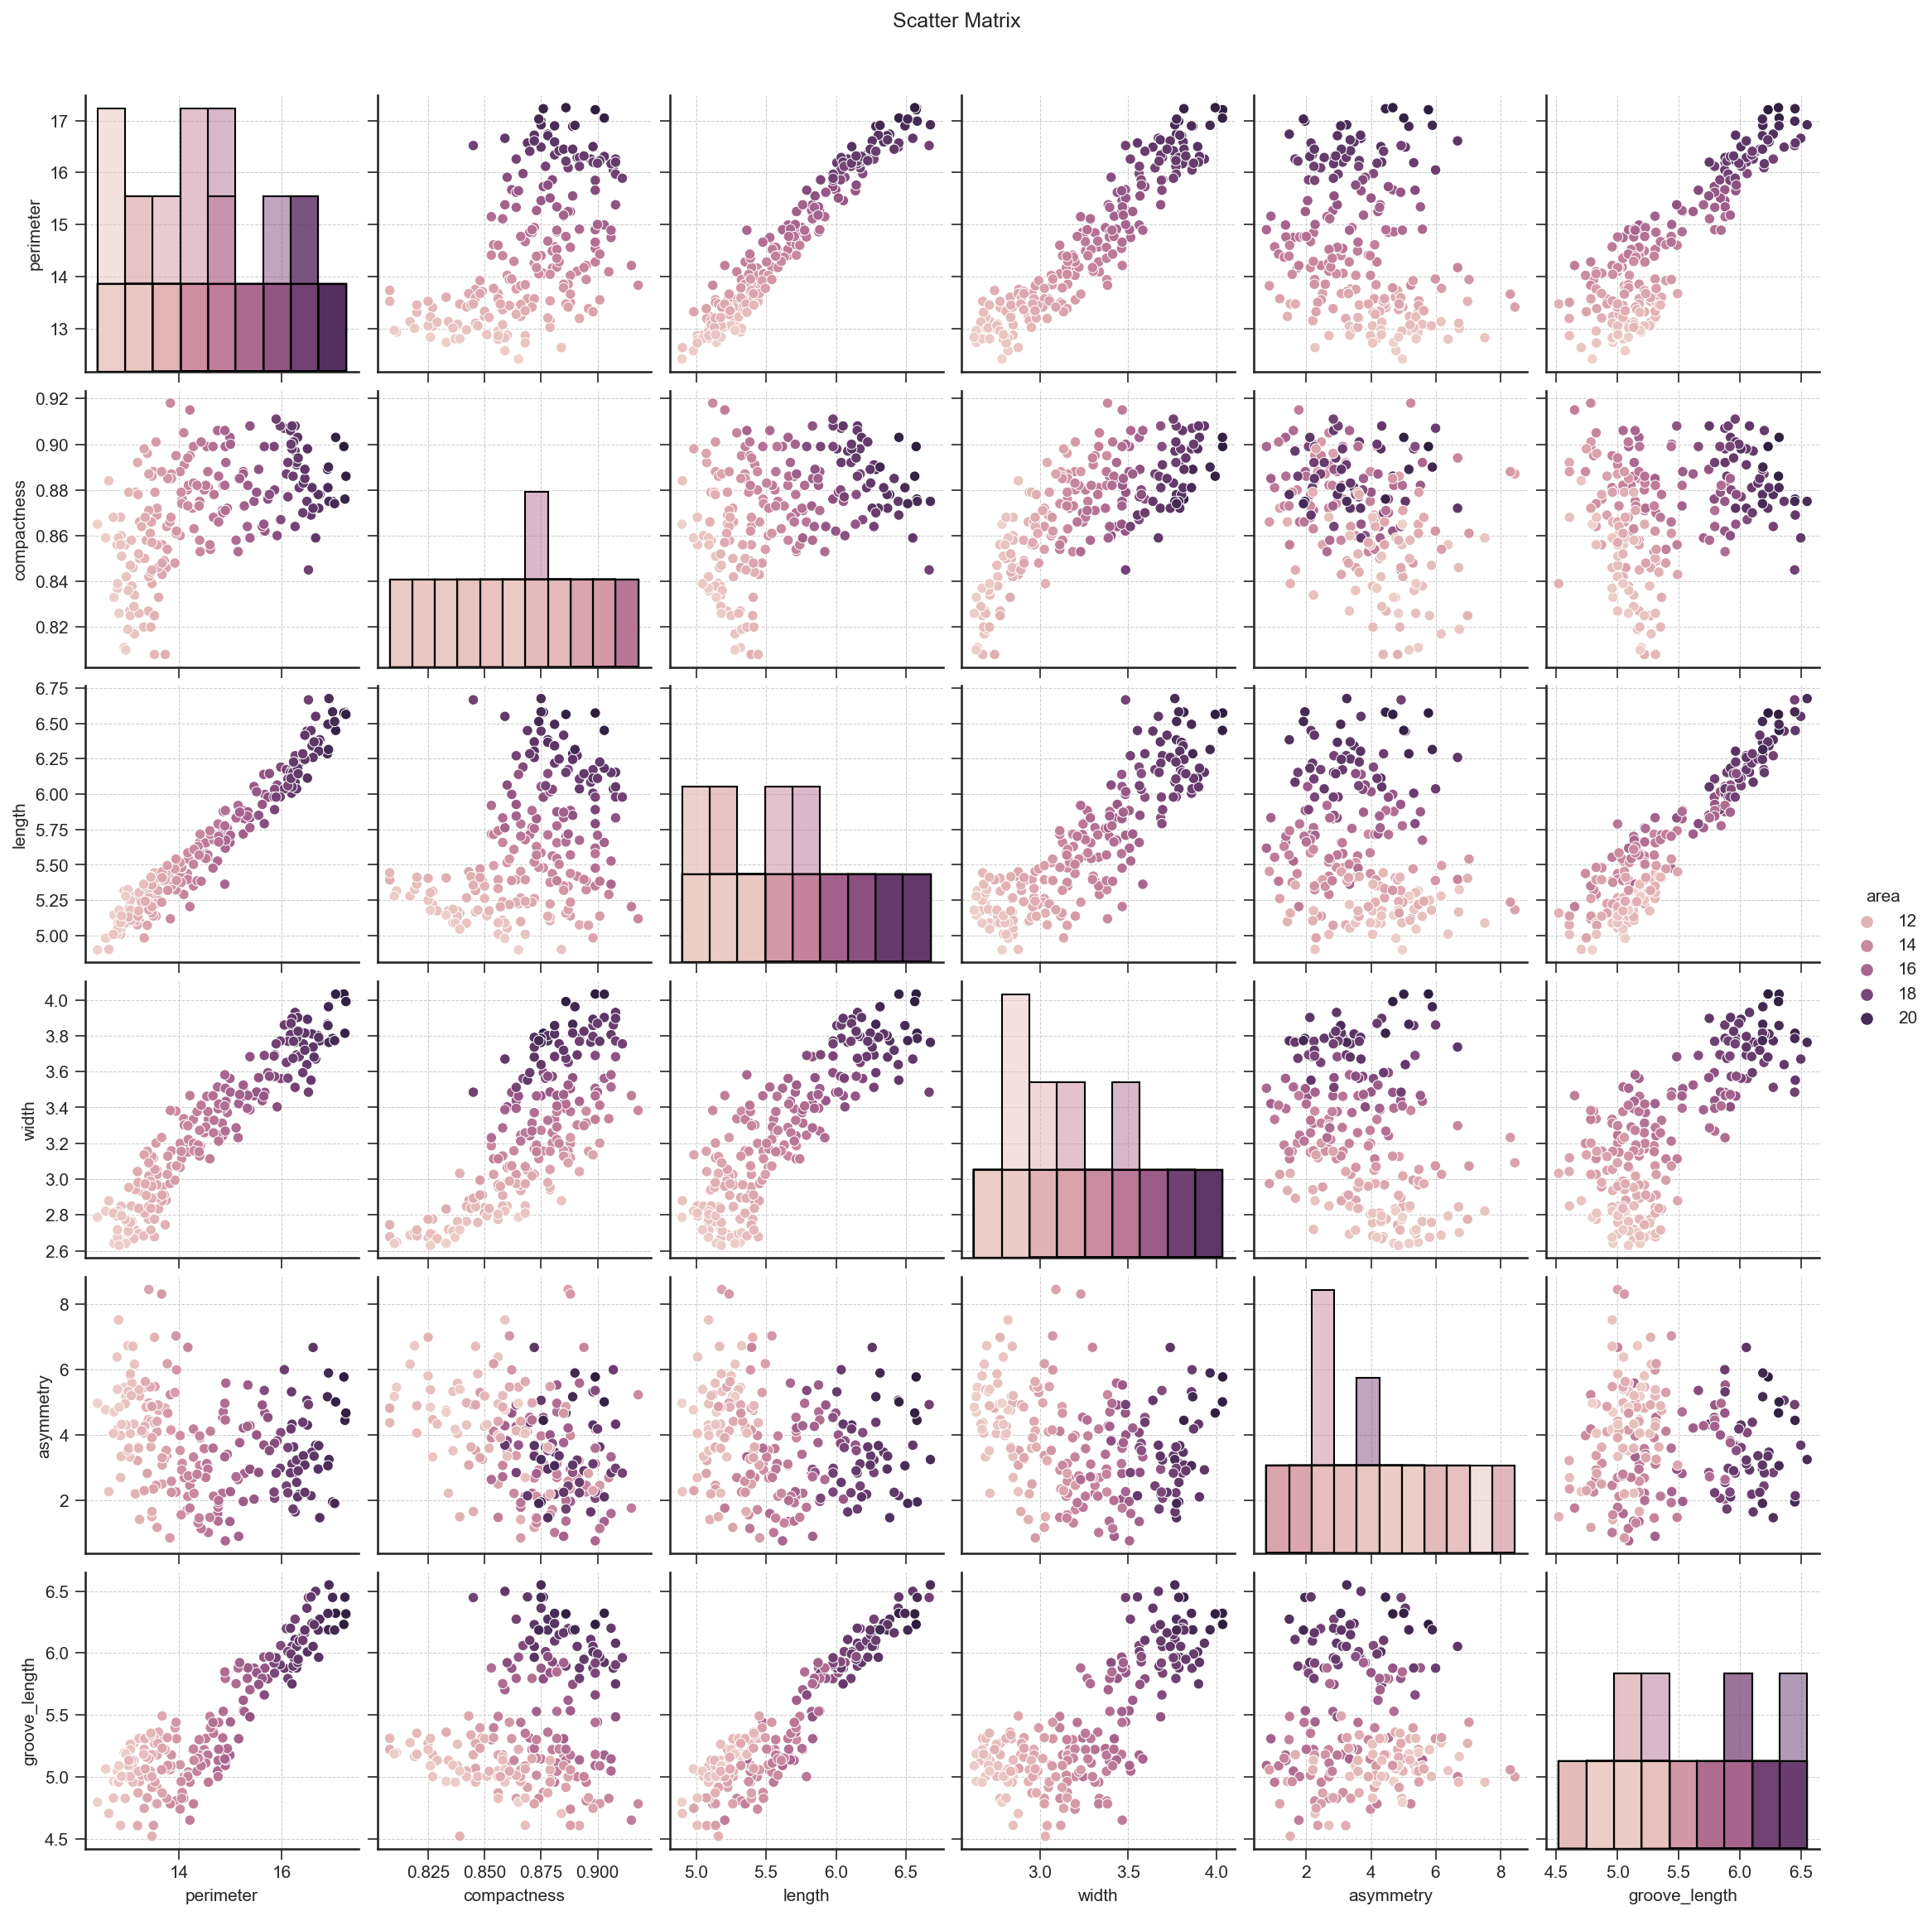

In [21]:
pair_plot = sns.pairplot(seeds, hue='area', diag_kind='hist')
pair_plot.fig.suptitle('Scatter Matrix', y=1.03)

### Performing PCA
<hr style="border:1px solid black"> </hr>

-`PCA` to decrease the dimensionality of a dataset, project it onto a new set of orthogonal axes known as principle components. Plot the same using `sns.pairplot`
<br>**Knowledge gained**: Few culsters are apparent in 2D, and the density of data points in 2D does not differ greatly, thus we will perform our clutering analysis using **KMeans** and **Gaussian Mixtures**. We will continue to test models with varied numbers of clusters ranging from 2 to 8, because PCA is only an estimate and there may be higher dimensional linkages or groups that we may overlook.

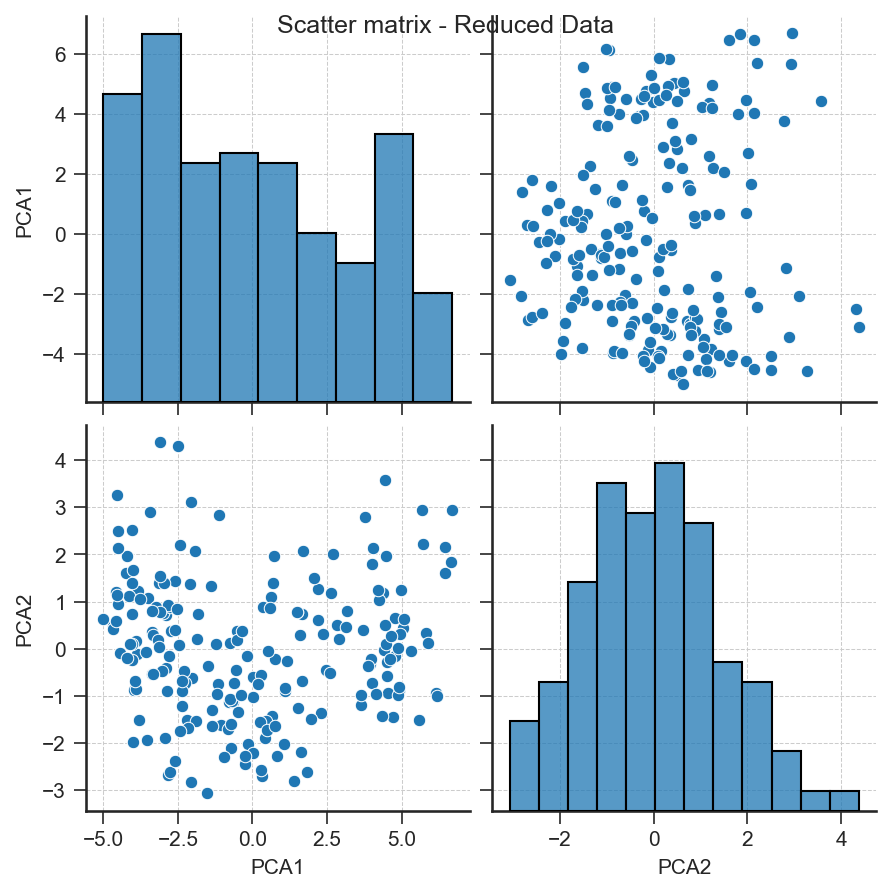

In [245]:
seeds_pca = PCA(n_components=2)
seeds_pca_df = pd.DataFrame(
    data=seeds_pca.fit_transform(seeds), columns=["PCA1", "PCA2"]
)

# Scatter matrix of seeds data
sns.pairplot(seeds_pca_df, height=3)
plt.suptitle("Scatter matrix - Reduced Data")
plt.show()


<hr style="border:2px solid black"> </hr>

## Clustering

<hr style="border:1px solid black"> </hr>

**K-means Model**

The main highlights of this code are:
<br>-A for loop is used to do K-Means clustering on the data for various clusters ranging from 2 to 8 using `for in range`.
<br>-The silhouette score is computed and added to a list`silhouette_scores` for each number of clusters`score`. The silhouette score indicates how well the clusters are separated.
<br>-A figure with subplots`plt.subplots` is constructed and looped through to generate scatterplots`ax[row, col].scatter` of the data coloured by cluster assignment. The silhouette scores are placed along the figure's top.
<br>**Knowledge gained**: 
<br>-Plot below represent 7 Kmeans clusters perfomed on PCA data
<br>-One of the key highlighting point is the Silhouette score which ranges from $[-1, 1]$
<br>-The silhouette score quantifies how successfully clusters in a dataset are separated. It is derived by taking the silhouette coefficient from each sample and average it.
<br>- $+1 \implies$ instance is well inside its own cluster and far from neighbourhoods
<br>- $-1 \implies$ assigned to wrong cluster
<br>- $0 \implies$ cluster boundary

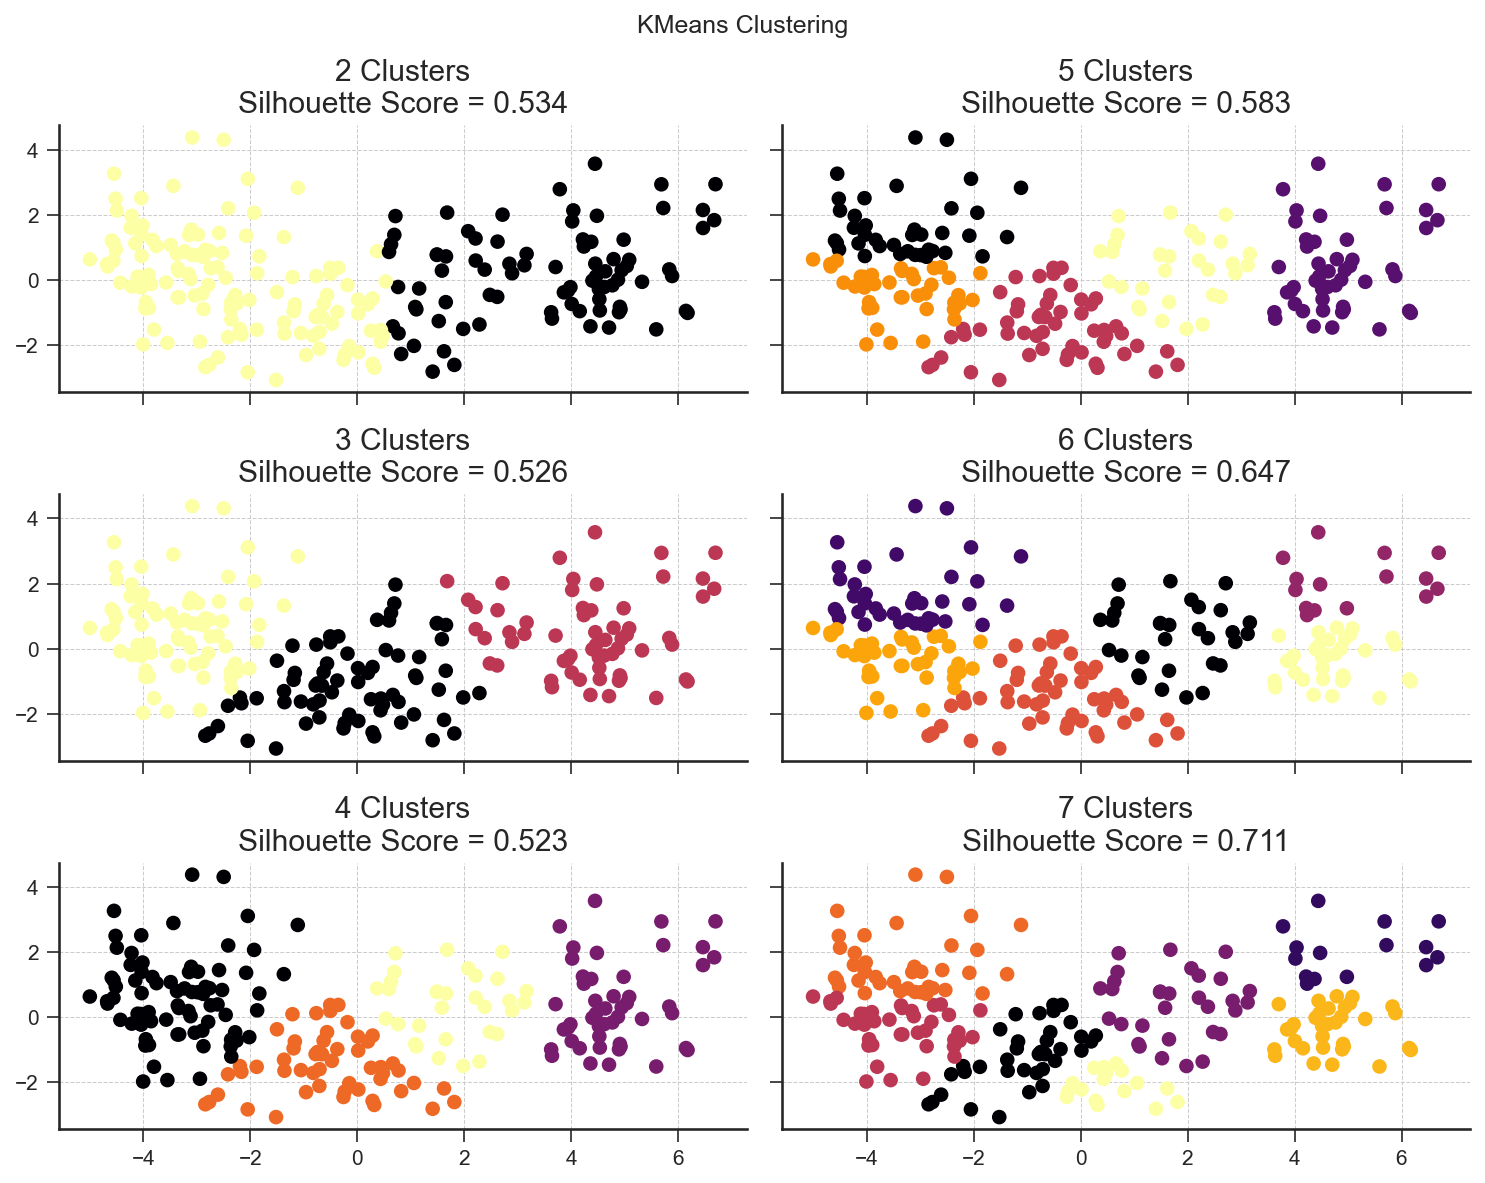

In [240]:
# Create an empty list to store the silhouette scores
silhouette_scores = []

# Loop through the number of clusters to use for k-means
for n in range(2, 8):
    # Perform k-means clustering on the PCA data
    kmeans = KMeans(n_clusters=n)
    seeds_pca_df[f'{n}_clusters'] = kmeans.fit_predict(seeds_pca_df)
    
    # Calculate the silhouette score for the current number of clusters
    score = silhouette_score(seeds_pca_df, seeds_pca_df[f'{n}_clusters'])
    
    # Append the silhouette score to the list
    silhouette_scores.append(score)

# Create a figure with 3 rows and 3 columns of subplots
fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(10, 8))

# Loop through each row and column in the figure
for row in range(3):
    for col in range(2):
        # Set the color palette for the current subplot
        n_clusters = 3*col + row + 2
        color_map = plt.cm.get_cmap('inferno', n_clusters)
        
        # Create a scatterplot on the current subplot using the 'PCA1' and 'PCA2' columns as the x and y values, respectively
        ax[row, col].scatter(seeds_pca_df['PCA1'], seeds_pca_df['PCA2'], 
                             c=seeds_pca_df[f'{n_clusters}_clusters'], cmap=color_map)
        
        # Set the title of the current subplot
        ax[row, col].set_title(f"{n_clusters} Clusters\nSilhouette Score = {silhouette_scores[n_clusters-2]:.3f}")
        
        # Add a grid to the current subplot
        ax[row, col].grid(True)

# Add a title to the figure
plt.suptitle("KMeans Clustering")

# Tighten the layout of the figure
fig.tight_layout()

-A bar plot of silhouette scores for a given number of clusters is plotted, `labels` are extracted from a dataframe `kmeans_labels_df` and `silhouette_samples` function is being called to evalute the silhouette scores for each data point in the `seeds`dataframe. A figure and axis are created using `plt.subplots()` and plotted using `plt.show`.
<br>**Knowledge gained**: A data point's silhouette score is a measurement of how similar it is to other data points in its own cluster as opposed to other clusters. When a data point has a high silhouette score, it is well matched to its own cluster.

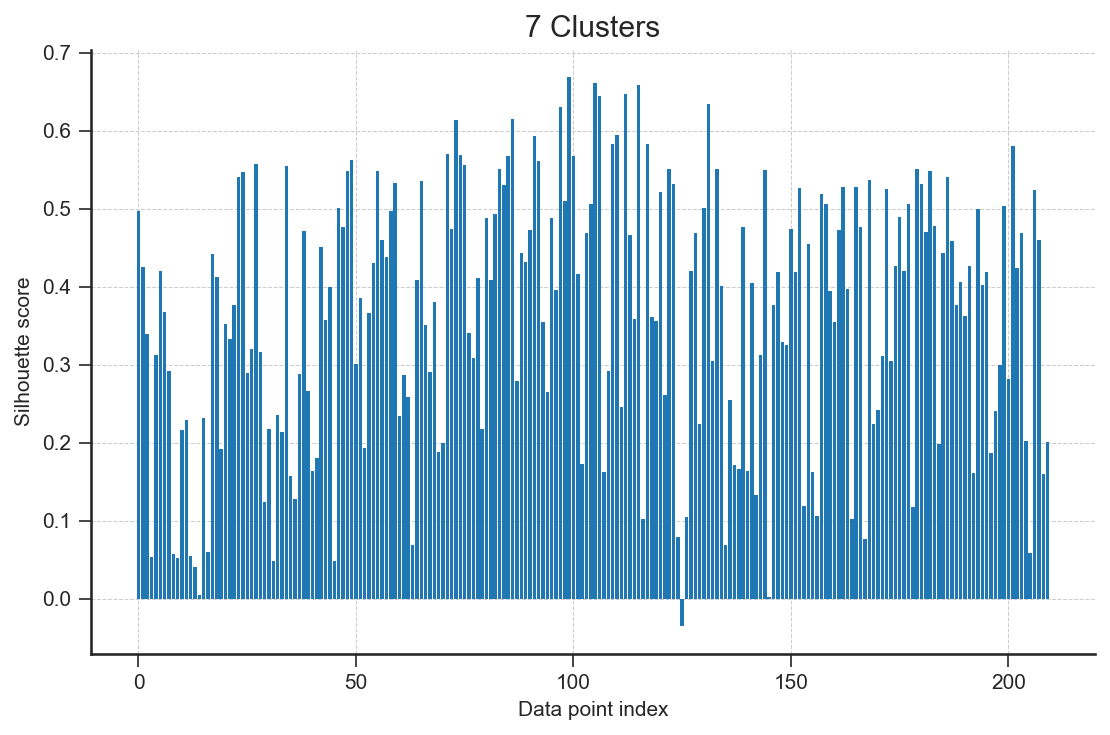

In [247]:
# Extract cluster labels
labels = kmeans_labels_df[f"{n}_clusters_labels"]

# Compute silhouette scores
silhouette_scores = silhouette_samples(seeds, labels)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the silhouette scores
ax.bar(range(len(silhouette_scores)), silhouette_scores)

# Add a title and axis labels
ax.set_title(f"{n} Clusters")
ax.set_xlabel("Data point index")
ax.set_ylabel("Silhouette score")

# Show the plot
plt.show()


-A scatter plot is genrated `plt.scatter()` using the x and y coordinates from the "PCA1" and "PCA2" columns in the `kmeans_labels_df` dataframe.

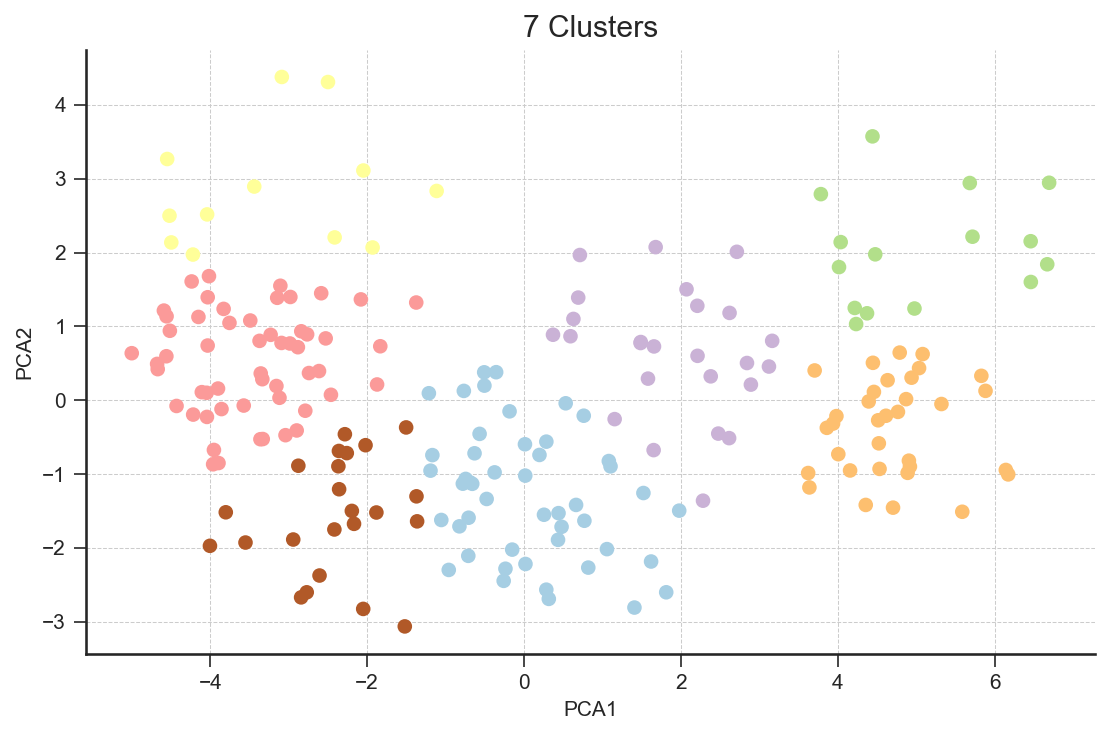

In [246]:
# Extract cluster labels
labels = kmeans_labels_df[f"{n}_clusters_labels"]

# Extract PCA coordinates
x = kmeans_labels_df["PCA1"]
y = kmeans_labels_df["PCA2"]

# Create a scatter plot
plt.scatter(x, y, c=labels, cmap="Paired")

# Add a title and axis labels
plt.title(f"{n} Clusters")
plt.xlabel("PCA1")
plt.ylabel("PCA2")

# Show the plot
plt.show()


-Determining Optimal number of clusters for a K-means clustering model using Elbow method. K-means `model` is fitted `fit(seeds_pca_df)` for a range of values of K. For each choice of K, plotting using`plt.plot` the sum of squared distances between the data points and their associated cluster centroids.

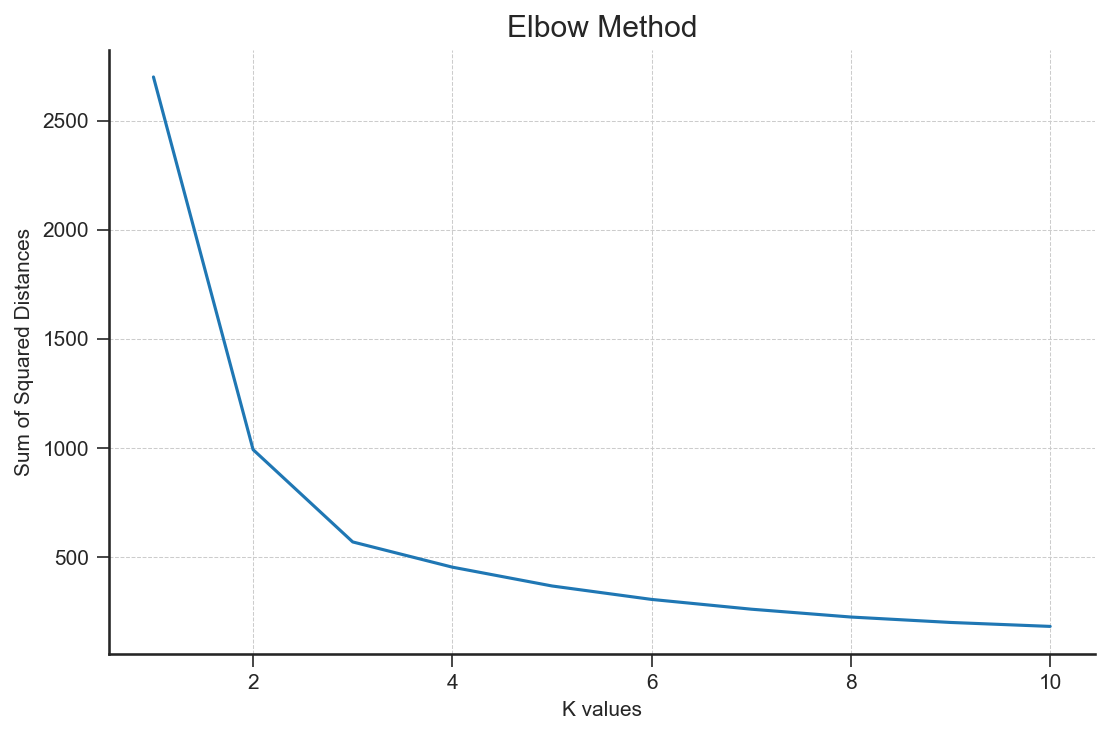

In [248]:
# Choosing a random range of values for K to perform the elbow technique
K = range(1,11)
sum_of_squared_distances = []
# Using Scikit Learn’s KMeans Algorithm to find sum of squared distances
for k in K:
    model = KMeans(n_clusters=k).fit(seeds_pca_df)
    sum_of_squared_distances.append(model.inertia_)
plt.plot(K, sum_of_squared_distances)
plt.xlabel('K values')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()

<hr style="border:1px solid black"> </hr>

**Gaussian Mixture Model**

-GMM (Gaussian Mixture Model) clustering algorithm is used for clustering a data set and plot the results. 
The main highlights of this code are:
<br>-A for loop is used to do GMM clustering on the data for various clusters ranging from 2 to 8 using `for in enumerate`.
<br>-The silhouette score is computed and added to a list`silhouette_scores` for each number of clusters`score`. The silhouette score indicates how well the clusters are separated.
<br>-A figure with subplots`plt.subplots` is constructed and looped through to generate scatterplots`ax[row, col].scatter` of the data coloured by cluster assignment. The silhouette scores are placed along the figure's top.
<br>**Knowledge gained**: Implementation of GMM is similar as K-means.
Subplot is created for each number of clusters, and a scatter plot is produced showing the resulting clusters.

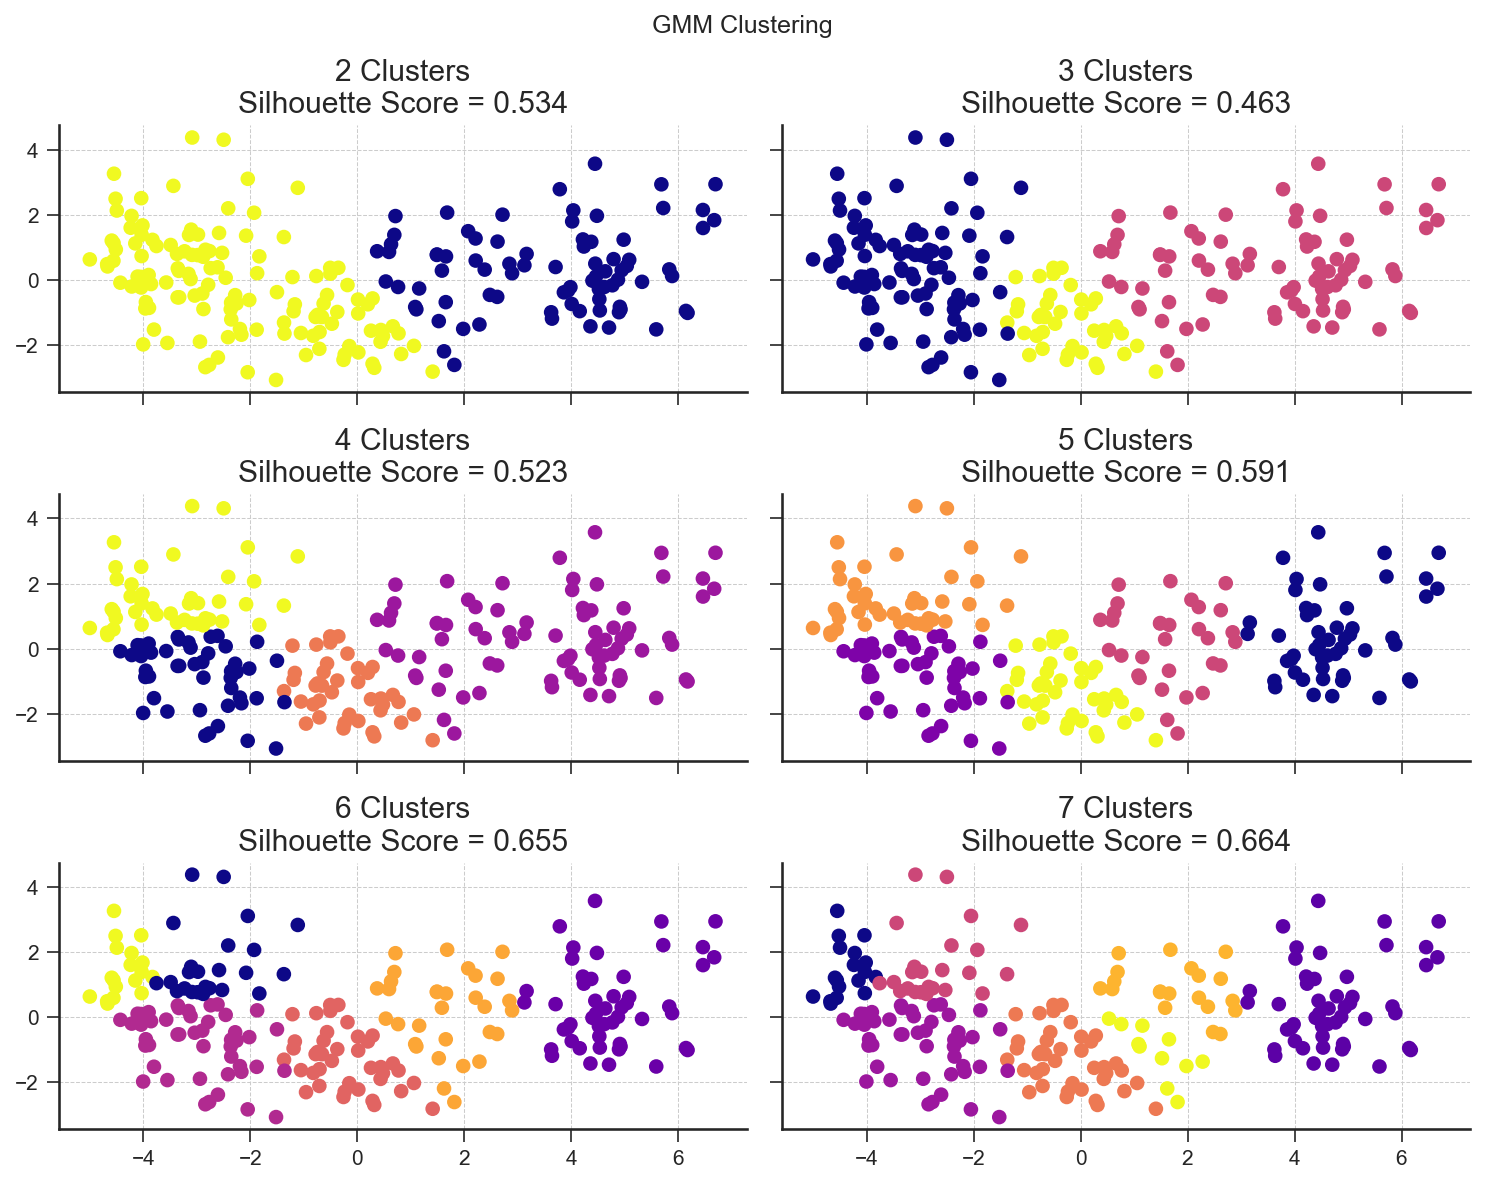

In [249]:
# Initialize lists to store the silhouette scores and WCSS
silhouette_scores = []

# Set the range of n_clusters to test
n_clusters_range = range(2, 8)

# Create a figure and axis
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(10, 8))

# Loop through each value of n_clusters
for i, n_clusters in enumerate(n_clusters_range):
    # Perform GMM clustering on the PCA data
    gmm = GMM(n_components=n_clusters)
    seeds_pca_df[f'{n_clusters}_clusters'] = gmm.fit_predict(seeds_pca_df)
    
    # Compute the silhouette score for the current clustering model
    silhouette_scores.append(silhouette_score(seeds_pca_df, seeds_pca_df[f'{n_clusters}_clusters']))
    
    # Get the row and column indices for the current subplot
    row = i // 2
    col = i % 2
    
    # Set the color palette for the current subplot
    color_map = plt.cm.get_cmap('plasma', n_clusters)
    
    # Create a scatterplot on the current subplot using the 'PCA1' and 'PCA2' columns as the x and y values, respectively
    ax[row, col].scatter(seeds_pca_df['PCA1'], seeds_pca_df['PCA2'], 
                         c=seeds_pca_df[f'{n_clusters}_clusters'], cmap=color_map)
    
    # Set the title of the current subplot
    ax[row, col].set_title(f"{n_clusters} Clusters\nSilhouette Score = {silhouette_scores[i]:.3f}")
    
    # Add a grid to the current subplot
    ax[row, col].grid(True)

# Add a title to the figure
fig.suptitle("GMM Clustering")

# Tighten the layout of the figure
fig.tight_layout()

# Show the figure
plt.show()

-Evaluating two clustering models K-Means and Gaussian Mixture Model (GMM) and the evaluation metrics for both models are printed.

In [253]:
# Set the number of clusters
n_clusters = 8

# Fit and evaluate the KMeans model
kmeans = cluster.KMeans(n_clusters=n_clusters)
kmeans.fit(seeds)
kmeans_labels = kmeans.labels_
kmeans_inertia = kmeans.inertia_
kmeans_silhouette_score = silhouette_score(seeds, kmeans_labels)

# Fit and evaluate the GMM model
gmm = GMM(n_components=n_clusters)
gmm_labels = gmm.fit_predict(seeds_pca_df)
gmm_bic = gmm.bic(seeds_pca_df)
gmm_aic = gmm.aic(seeds_pca_df)
gmm_silhouette_score = silhouette_score(seeds_pca_df, gmm_labels)

# Print the evaluation metrics
print(f"KMeans Inertia: {kmeans_inertia:.3f}")
print(f"KMeans Silhouette Score: {kmeans_silhouette_score:.3f}")
print(f"GMM BIC: {gmm_bic:.3f}")
print(f"GMM AIC: {gmm_aic:.3f}")
print(f"GMM Silhouette Score: {gmm_silhouette_score:.3f}")


KMeans Inertia: 240.570
KMeans Silhouette Score: 0.360
GMM BIC: -11426.884
GMM AIC: -12628.496
GMM Silhouette Score: 0.612


-A figure with two bar charts, one for the inertia and one for the silhouette score is plotted.

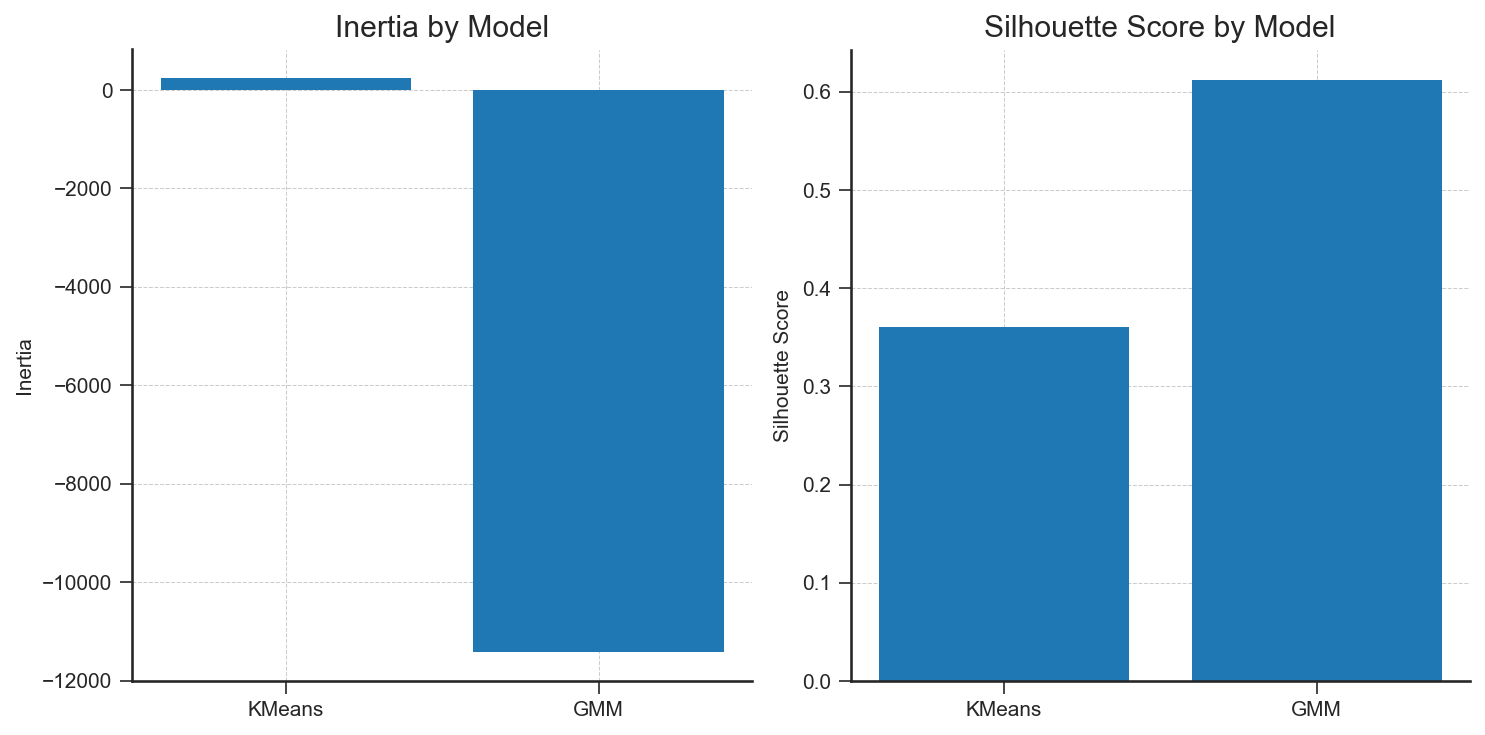

In [255]:
# Set the labels for the x-axis
model_labels = ['KMeans', 'GMM']

# Set the values for each bar
inertia = [kmeans_inertia, gmm_bic]
silhouette = [kmeans_silhouette_score, gmm_silhouette_score]

# Set the positions of the x-axis ticks
x_pos = range(len(model_labels))

# Create the plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create the first bar chart
ax1.bar(x_pos, inertia, align='center')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(model_labels)
ax1.set_ylabel('Inertia')
ax1.set_title('Inertia by Model')

# Create the second bar chart
ax2.bar(x_pos, silhouette, align='center')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(model_labels)
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score by Model')

# Show the plot
plt.show()

## Result

<br> The above analysis reveals that a Gaussian mixture model (GMM) with a high silhouette score is preferable to a K-means model because it indicates that the model has identified patterns in the data that lead to natural groupings, or clusters. A K-means model, on the other hand, produces clusters that are more equally sized and spherical, which may or may not represent the underlying structure of the data. Also the lower inertia is preferred because it means that the clusters are more tightly packed.